In [49]:
"""
Tutorial: Fly-by Induced Binary Black Hole Mergers in the Galactic Field
==============================================================================

This script demonstrates the full workflow for simulating Fly-by Induced
Binary Black Hole mergers in the Milky Way Field.

It covers:
1. Initialize/Re-run the simulation with custom galaxy properties.
2. Sample merger eccentricities (e.g., for LIGO rate estimation).
3. Analyze the underlying "Progenitor Population" (the static population of binaries destined to merge).
4. Generate "Snapshots" of the current MW Field fly-by induced high-e BBH population for LISA analysis.

References:
- Michaely & Perets (2019) [ApJL 887 L36]
- Raveh et al. (2022) [MNRAS 514.4246R]
- Michaely & Perets (2022) [ApJ 936 184]
- Xuan et al. (2024) [ApJ 965 148]
==============================================================================
"""

import numpy as np
from Field_modeling import Field_BBH  # Import core module
import scipy.constants as sciconsts

# ==============================================================================
# SECTION 0: Initialize / Re-run Simulation (Optional)
# ==============================================================================
# If this is the first run, or if you want to change physical parameters
# (e.g., BH mass, galaxy density), uncomment the code below.
# This will run the Monte Carlo simulation and overwrite files in ./data/.

print("\n=== STEP 0: Generating Custom MW Field BBH Population ===")
# Uncomment this block to run a fresh simulation.
# This will overwrite files in ./data/
Field_BBH.simulate_and_save_default_population(
    # --- Simulation Precision Control ---
    n_sim_samples=200000,  # Initial Monte Carlo sample number (Recommended: 1e5 - 1e6)
    target_N=100000,  # Final output number of BBH merger progenitor samples (Resampled)

    # --- Physics Parameters ---
    m1=10 * Field_BBH.m_sun,  # Mass of primary BH [M_sun]
    m2=10 * Field_BBH.m_sun,  # Mass of secondary BH [M_sun]

    mp=0.6 * Field_BBH.m_sun,  # Mass of the typical fly-by perturber (e.g., Field Star) [M_sun]
    fgw=10,  # GW frequency threshold for "Merger" / LIGO band eccentricity calculation [Hz]

    # --- Galaxy Structure Parameters (Milky Way Model) ---
    n0=0.1 / (Field_BBH.pc ** 3),  # Stellar number density normalization in solar neighborhood (1/pc^3)
    rsun=8e3 * Field_BBH.pc,  # Distance from Galactic Center to Sun [geometrized distance]
    Rl=2.6e3 * Field_BBH.pc,  # Galaxy scale length [geometrized distance]
    h=1e3 * Field_BBH.pc,  # Galaxy scale height [geometrized distance]
    sigmav=50e3 / sciconsts.c,  # Velocity dispersion (v/c)
    fbh=7.5e-4,  # Fraction of BHs in the stellar population

    # --- Formation History ---
    formation_mod='starburst',  # 'starburst' (instantaneous) or 'continuous'
    age=10e9 * Field_BBH.years,  # Galaxy age (limits the maximum interaction time T)

    # --- Grid Ranges ---
    rrange_kpc=[0.5, 15],  # Simulated MW radius spatial range [kpc]
    arange_log=[2, 4.5],  # BBH semi-major axis range log10(a/AU)
    blocknum=29  # Number of radial bins (blocks) for the galaxy grid
)
print("Simulation finished and data saved.")


=== STEP 0: Generating Custom MW Field BBH Population ===
Initializing fresh simulation...
Running MC simulation ...
Resampling population based on different fly-by induced BBH merger rates at different initial SMA...
Simulation Done. Merger Rate in the galaxy: 0.23079 /Myr. Merger Sample Size: 100000
Data saved to /content/LISAeccentric/Field_modeling/data
Simulation finished and data saved.



=== FEATURE 1: Sampling Merger Eccentricities ===
Sampling 5000 systems based on weighted merger rates...
Sample Mean e: 6.3761e-03
Example output (first 3): [4.44437875e-05 4.53618787e-06 1.39205361e-05]


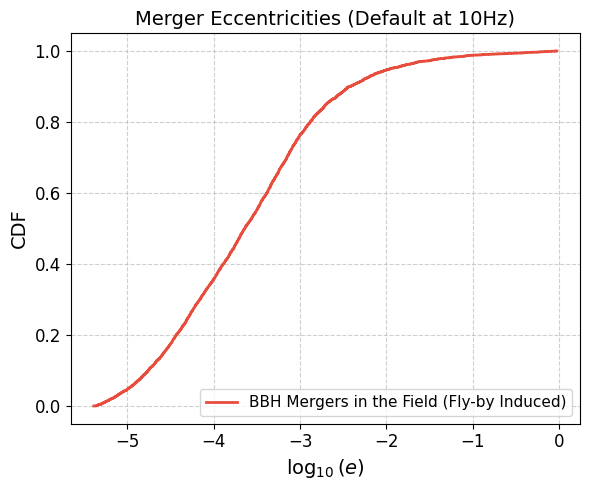

In [50]:
# ==============================================================================
# FEATURE 1: Merger Eccentricity Sampling (LIGO Band)
# ==============================================================================
# Function: Randomly sample N merger eccentricities from the simulated library
# based on merger rate weights. This simulates the eccentricity distribution
# of Field BBHs as they enter the LIGO/Virgo band (f_GW = 10Hz).

print("\n=== FEATURE 1: Sampling Merger Eccentricities ===")
N = 5000
print(f"Sampling {N} systems based on weighted merger rates...")

# Load pre-trained model from ./data directory and sample
e_samples = Field_BBH.generate_eccentricity_samples(size=N)

print(f'Sample Mean e: {np.mean(e_samples):.4e}')
print('Example output (first 3):', e_samples[:3])

# Plot Cumulative Distribution Function (CDF) of eccentricities
#
Field_BBH.plot_eccentricity_cdf(e_samples, label="BBH Mergers in the Field (Fly-by Induced)")


=== FEATURE 2: Analyzing Underlying Merger Progenitor Population ===
Total simulated progenitors in library: 100000


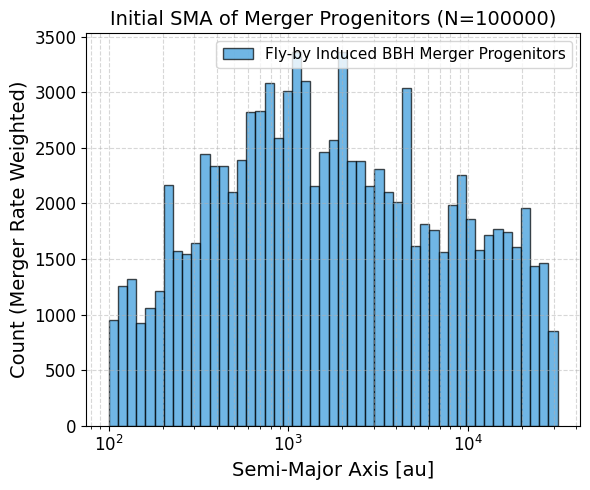

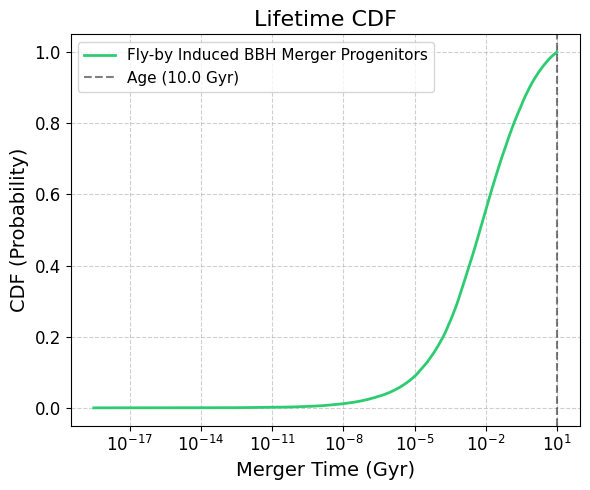

In [51]:
# ==============================================================================
# FEATURE 2: Accessing Progenitor Population (Library Analysis)
# ==============================================================================
# Access the underlying simulated progenitor population.
# This represents the static library of ALL binaries that are destined to merge near current MW age.
# Columns: [a_initial, e_initial, e_final, Dl, rate, lifetime, tau]

print("\n=== FEATURE 2: Analyzing Underlying Merger Progenitor Population ===")
progenitors = Field_BBH.get_merger_progenitor_population()
print(f"Total simulated progenitors in library: {len(progenitors)}")

# 2.1 Plot SMA Distribution of Progenitors
# This shows the distribution of semi-major axes for systems that will eventually merge.
#
Field_BBH.plot_progenitor_sma_distribution(bins=50)

# 2.2 Plot Lifetime CDF
# Shows the distribution of merger times (delay times) for the population.
#
Field_BBH.plot_lifetime_cdf()


=== FEATURE 3.1: Single MW Realization ===
Data Format Example: [Label, Dist(kpc), SMA(au), ecc, m1, m2, SNR]
System: D=10.2kpc, a=8.3AU, e=0.9988, SNR=0.07
System: D=6.2kpc, a=40.5AU, e=0.9998, SNR=0.04


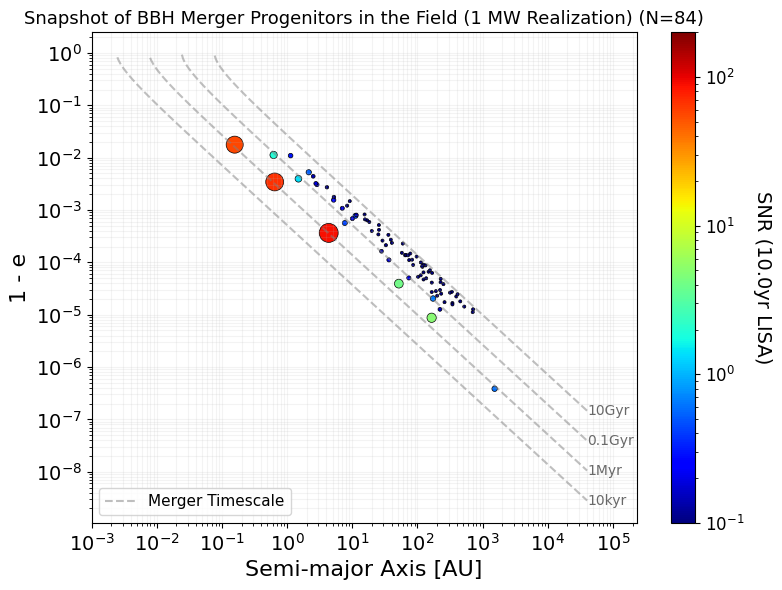

In [54]:
# ==============================================================================
# FEATURE 3: Snapshot Generation (LISA Band / Current State)
# ==============================================================================
# Generate a "snapshot" containing BBH systems that currently exist in the MW Field.
# These systems have been excited to high eccentricity via fly-by and will merge
# within the specified future `t_window`.
#
# NOTE: The time window `t_window_Gyr` should ideally NOT exceed the galaxy age (e.g., 10 Gyr).
# Extending the window beyond the age implies looking for systems that were
# likely removed from the simulation earlier.

# --- 3.1: Single MW Realization ---
# Generates one random realization of the Milky Way based on the calculated merger rate.
"""
Output Data Format:
Each system in the returned list has the following columns:
[0] Label (str)      : 'Field'
[1] Distance (float) : Distance from Sun [kpc]
[2] SMA (float)      : Current Semi-major Axis [AU]
[3] Eccentricity     : Current Eccentricity (0 <= e < 1)
[4] Mass 1 (float)   : Mass of primary BH [M_sun] (default 10)
[5] Mass 2 (float)   : Mass of secondary BH [M_sun] (default 10)
[6] SNR (float)      : Signal-to-Noise Ratio (default 10yr LISA observation)
"""
print("\n=== FEATURE 3.1: Single MW Realization ===")
t_obs = 10.0  # LISA Observation duration in years (affects SNR)
single_mw = Field_BBH.get_single_mw_realization(t_window_Gyr=10.0, tobs_yr=t_obs)
if len(single_mw) > 0:
    # Print the first two rows to show data format
    print("Data Format Example: [Label, Dist(kpc), SMA(au), ecc, m1, m2, SNR]")
    for row in single_mw[:2]:
        print(f"System: D={row[1]:.1f}kpc, a={row[2]:.1f}AU, e={row[3]:.4f}, SNR={row[6]:.2f}")
else:
    print("No events found in this realization (Poisson fluctuation).")

# Plot Phase Space (a vs 1-e) with SNR color coding
#
Field_BBH.plot_mw_field_bbh_snapshot(
    single_mw,
    title="Snapshot of BBH Merger Progenitors in the Field (1 MW Realization)",
    tobs_yr=t_obs
)


=== FEATURE 3.2: 10 MW Realizations ===
Total systems found in 10 realizations: 801


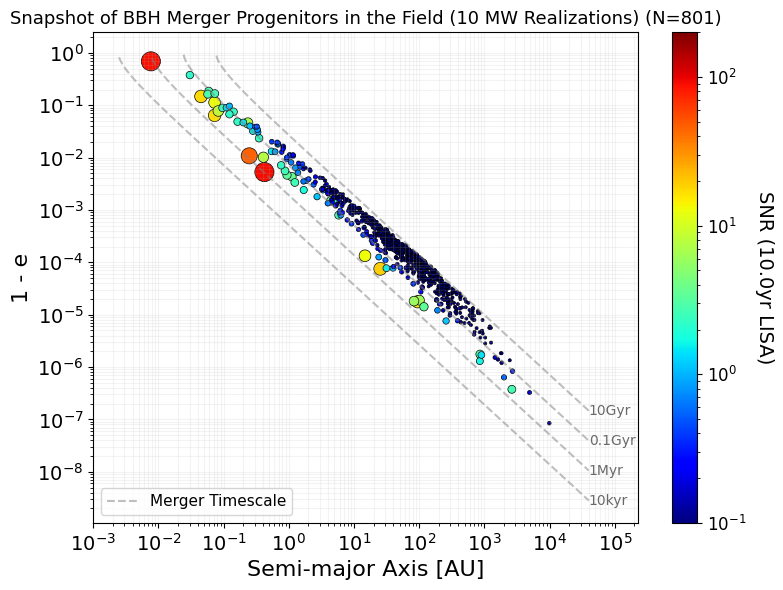


=== FEATURE 3.3: Generating 500 Random Systems ===
Generated 500 systems (Forced Sample).


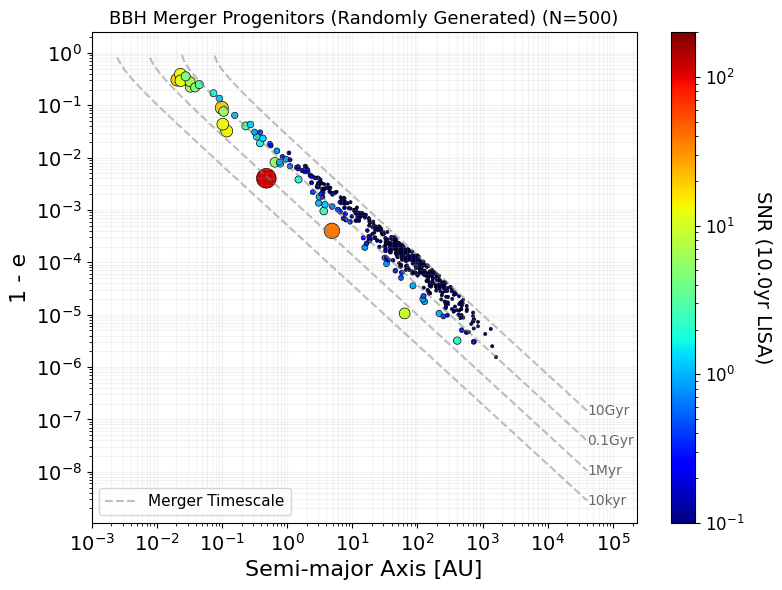

In [55]:
# --- 3.2: Multiple Realizations ---
# Stacks multiple realizations (e.g., 10 MWs) to see the variance or get better statistics.
print("\n=== FEATURE 3.2: 10 MW Realizations ===")
multi_mw = Field_BBH.get_multi_mw_realizations(n_realizations=10, t_window_Gyr=10.0, tobs_yr=t_obs)

print(f"Total systems found in 10 realizations: {len(multi_mw)}")
Field_BBH.plot_mw_field_bbh_snapshot(
    multi_mw,
    title="Snapshot of BBH Merger Progenitors in the Field (10 MW Realizations)",
    tobs_yr=t_obs
)

# --- 3.3: Arbitrary Number of Systems (Fixed N) ---
# Useful for making high-resolution plots or statistical studies where you need
# a fixed number of samples regardless of the physical rate.
print("\n=== FEATURE 3.3: Generating 500 Random Systems ===")
random_500 = Field_BBH.get_random_systems(n_systems=500, t_window_Gyr=10.0, tobs_yr=t_obs)

print(f"Generated {len(random_500)} systems (Forced Sample).")
Field_BBH.plot_mw_field_bbh_snapshot(
    random_500,
    title="BBH Merger Progenitors (Randomly Generated)",
    tobs_yr=t_obs
)